In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [3]:
# Load the main dataset
raw_df = pd.read_csv('ml_project1_data.csv')
raw_df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


## Customer Profile Analysis

These are the columns related to Customer Profile Information 

| categorical 	     | numerical 	            |
|-----------	     |-----------	            |
|Education - ordinal | Income  - continuous  	|
|Marital - nominal   | Kidhome  - discrete 	    |
|                    | Teenhome - discrete 	    |
|      	             | dtCustomer - interval    |
|                    | yearbirth - interval     |



C:\Users\punee\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\punee\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\punee\AppData\Local\Temp\ipykernel_30616\973446798.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


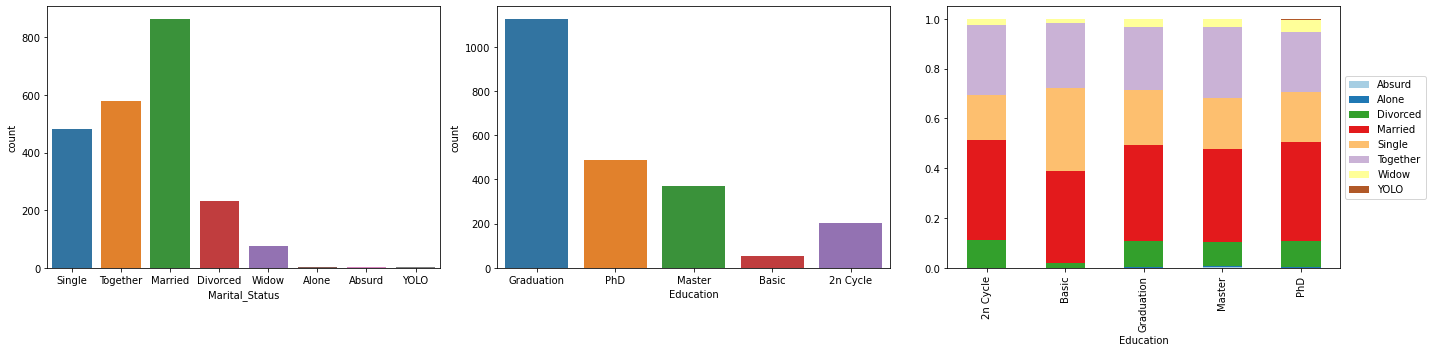

In [4]:
# Taking a look at the categorical variables
fig, ax = plt.subplots(1,3, figsize=(20,5))
sns.countplot(raw_df['Marital_Status'], ax=ax[0])
sns.countplot(raw_df['Education'], ax=ax[1])
df_plot = raw_df.groupby(['Marital_Status', 'Education']).size().reset_index().pivot(columns='Marital_Status', index='Education', values=0)
df_plot.apply(lambda x: x/x.sum(), axis=1).plot(kind='bar', stacked=True, ax=ax[2],  colormap='Paired')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.tight_layout()
fig.show()

In [5]:
df_plot

Marital_Status,Absurd,Alone,Divorced,Married,Single,Together,Widow,YOLO
Education,,,,,,,,
2n Cycle,NaN,NaN,23.0,81.0,37.0,57.0,5.0,NaN
Basic,NaN,NaN,1.0,20.0,18.0,14.0,1.0,NaN
Graduation,1.0,1.0,119.0,433.0,252.0,286.0,35.0,NaN
Master,1.0,1.0,37.0,138.0,75.0,106.0,12.0,NaN
PhD,NaN,1.0,52.0,192.0,98.0,117.0,24.0,2.0


### Data Transformations:

We need to perform several data transformations to prepare the dataset for analysis. Here are the necessary transformations:

#### 1. Age Transformation:
   - **Original Column**: `yearbirth`
   - **Transformed Column**: `customer_age` (in years)

#### 2. Customer Enrollment Duration Transformation:
   - **Original Column**: `dtCustomer`
   - **Transformed Column**: `customer_days` (customer's enrollment duration in days)

#### 3. Education Transformation:
   - **Original Column**: `Education`
   - **Transformed Columns**: 
     - `Basic`: boolean (0 or 1)
     - `Graduation`: boolean (0 or 1)
     - `2n Cycle`: boolean (0 or 1)
     - `Master`: boolean (0 or 1)
     - `PhD`: boolean (0 or 1)
   - **Ordinal Mapping**:
     - `Basic: 0`
     - `Graduation: 1`
     - `2n Cycle: 2`
     - `Master: 3`
     - `PhD: 4`

#### 4. Marital Status Transformation:
   - **Original Column**: `Marital`
   - **Transformed Columns** (using Dummy Variables):
     - `Married`: boolean (0 or 1)
     - `Together`: boolean (0 or 1)
     - `Single`: boolean (0 or 1)
     - `Alone`: boolean (0 or 1)
     - `Absurd`: boolean (0 or 1)
     - `YOLO`: boolean (0 or 1)
     - `Divorced`: boolean (0 or 1)
     - `Widow`: boolean (0 or 1)

These transformations will make the data more suitable for analysis and modeling, allowing us to work with meaningful features and variables.

In [6]:
# Create Customer Age Column
raw_df['Age'] = date.today().year - raw_df['Year_Birth']

# Number of days as a customer
raw_df['Customer_Days'] = (pd.to_datetime("now") - pd.to_datetime(raw_df['Dt_Customer'])) // np.timedelta64(1,'D')  

# Marital -> multiples using Dummy Variables
raw_df.loc[raw_df['Marital_Status'].isin(['Alone','Absurd','YOLO']), 'Marital_Status']  = 'Single'
dummy_marital = pd.get_dummies(raw_df['Marital_Status'], prefix='marital')
ifood_df = pd.concat([raw_df,dummy_marital],axis=1)

# Replace Educational to an ordinal number
dummy_edu_var_aux = pd.get_dummies(raw_df['Education'], prefix='education')
ifood_df = pd.concat([ifood_df, dummy_edu_var_aux], axis=1)

# Drop unused columns
ifood_df.drop(columns=['ID','Marital_Status','Education','Year_Birth','Dt_Customer'], inplace=True)

# Look of the new dataset
customer_columns = ['Age', 'Customer_Days', 'Income', 'Kidhome', 'Teenhome'] + dummy_marital.columns.to_list() + dummy_edu_var_aux.columns.to_list()

customer_df = ifood_df[customer_columns]
customer_df.head()

C:\Users\punee\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:2199: FutureWarning: The parsing of 'now' in pd.to_datetime without `utc=True` is deprecated. In a future version, this will match Timestamp('now') and Timestamp.now()
  result, tz_parsed = tslib.array_to_datetime(


,Age,Customer_Days,Income,Kidhome,Teenhome,marital_Divorced,marital_Married,marital_Single,marital_Together,marital_Widow,education_2n Cycle,education_Basic,education_Graduation,education_Master,education_PhD
0,66,4022,58138.0,0,0,0,0,1,0,0,0,0,1,0,0
1,69,3472,46344.0,1,1,0,0,1,0,0,0,0,1,0,0
2,58,3671,71613.0,0,0,0,0,0,1,0,0,0,1,0,0
3,39,3498,26646.0,1,0,0,0,0,1,0,0,0,1,0,0
4,42,3520,58293.0,1,0,0,1,0,0,0,0,0,0,0,1


In [7]:
ifood_df.columns

Index(['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response',
       'Age', 'Customer_Days', 'marital_Divorced', 'marital_Married',
       'marital_Single', 'marital_Together', 'marital_Widow',
       'education_2n Cycle', 'education_Basic', 'education_Graduation',
       'education_Master', 'education_PhD'],
      dtype='object')

In [8]:
# Sum of purchases
ifood_df['MntTotal'] = ifood_df.loc[:,['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts']].sum(axis=1)

# Regular Products
ifood_df['MntRegularProds'] = ifood_df.loc[:,'MntTotal'] - ifood_df.loc[:,'MntGoldProds']

# Campaigns Accepted
ifood_df['AcceptedCmpOverall'] = ifood_df.loc[:,['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']].sum(axis=1)

customer_columns_ext = customer_columns + ['MntTotal', 'MntRegularProds', 'MntGoldProds', 'AcceptedCmpOverall']

customer_df = ifood_df[customer_columns_ext]
customer_df.head(9)

,Age,Customer_Days,Income,Kidhome,Teenhome,marital_Divorced,marital_Married,marital_Single,marital_Together,marital_Widow,education_2n Cycle,education_Basic,education_Graduation,education_Master,education_PhD,MntTotal,MntRegularProds,MntGoldProds,AcceptedCmpOverall
0,66,4022,58138.0,0,0,0,0,1,0,0,0,0,1,0,0,1529,1441,88,0
1,69,3472,46344.0,1,1,0,0,1,0,0,0,0,1,0,0,21,15,6,0
2,58,3671,71613.0,0,0,0,0,0,1,0,0,0,1,0,0,734,692,42,0
3,39,3498,26646.0,1,0,0,0,0,1,0,0,0,1,0,0,48,43,5,0
4,42,3520,58293.0,1,0,0,1,0,0,0,0,0,0,0,1,407,392,15,0
5,56,3652,62513.0,0,1,0,0,0,1,0,0,0,0,1,0,702,688,14,0
6,52,3952,55635.0,0,1,1,0,0,0,0,0,0,1,0,0,563,536,27,0
7,38,3776,33454.0,1,0,0,1,0,0,0,0,0,0,0,1,146,123,23,0
8,49,3747,30351.0,1,0,0,0,0,1,0,0,0,0,0,1,44,42,2,0


array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Customer_Days'}>,
        <AxesSubplot:title={'center':'Income'}>],
       [<AxesSubplot:title={'center':'Kidhome'}>,
        <AxesSubplot:title={'center':'Teenhome'}>,
        <AxesSubplot:title={'center':'MntTotal'}>],
       [<AxesSubplot:title={'center':'MntRegularProds'}>,
        <AxesSubplot:title={'center':'MntGoldProds'}>,
        <AxesSubplot:title={'center':'AcceptedCmpOverall'}>]],
      dtype=object)

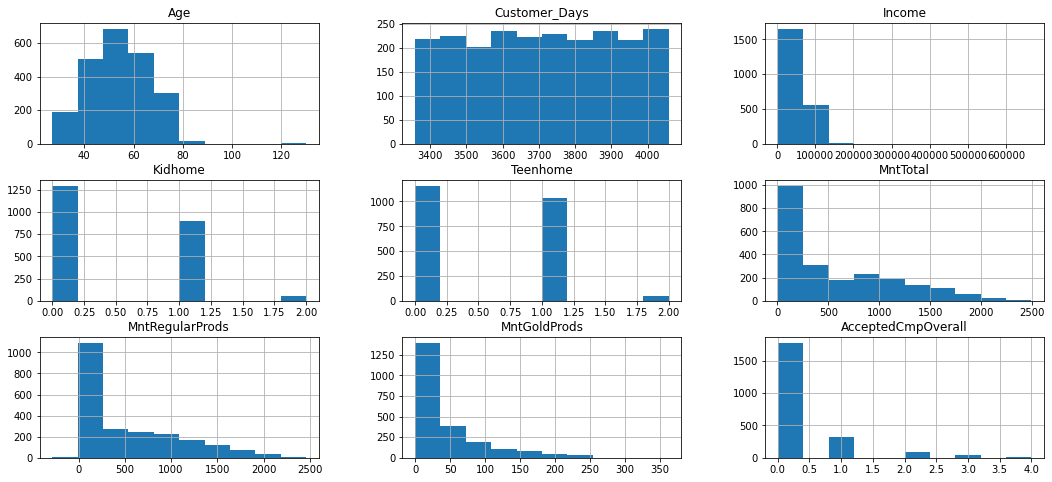

In [9]:
customer_df.hist( column = ['Age', 'Customer_Days', 'Income', 'Kidhome', 'Teenhome', 'MntTotal', 'MntRegularProds', 'MntGoldProds', 'AcceptedCmpOverall'], figsize=(18,8))

## Outliers and missing data in Income and Age columns

<AxesSubplot:>

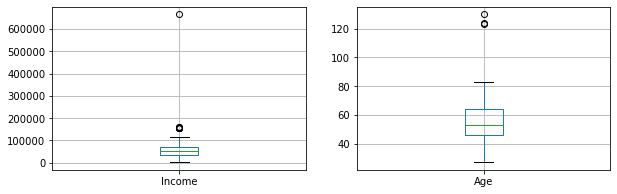

In [15]:
fig, ax = plt.subplots(1,2, figsize=(10,3))

customer_df.boxplot(column=['Income'], ax=ax[0])
customer_df.boxplot(column=['Age'], ax=ax[1])

In [13]:
ifood_df.isna().sum()

Income                  24
Kidhome                  0
Teenhome                 0
Recency                  0
MntWines                 0
MntFruits                0
MntMeatProducts          0
MntFishProducts          0
MntSweetProducts         0
MntGoldProds             0
NumDealsPurchases        0
NumWebPurchases          0
NumCatalogPurchases      0
NumStorePurchases        0
NumWebVisitsMonth        0
AcceptedCmp3             0
AcceptedCmp4             0
AcceptedCmp5             0
AcceptedCmp1             0
AcceptedCmp2             0
Complain                 0
Z_CostContact            0
Z_Revenue                0
Response                 0
Age                      0
Customer_Days            0
marital_Divorced         0
marital_Married          0
marital_Single           0
marital_Together         0
marital_Widow            0
education_2n Cycle       0
education_Basic          0
education_Graduation     0
education_Master         0
education_PhD            0
MntTotal                 0
M

In [14]:
ifood_df = ifood_df.dropna()

In [20]:
Q1 = ifood_df.Income.quantile(0.25)
Q3 = ifood_df.Income.quantile(0.75)
IQR = Q3 - Q1

Income_outliers = ifood_df[ifood_df.Income > Q3 + 1.5*IQR]
ifood_df = ifood_df[ifood_df.Income < Q3 + 1.5*IQR]
Income_outliers.head()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,marital_Together,marital_Widow,education_2n Cycle,education_Basic,education_Graduation,education_Master,education_PhD,MntTotal,MntRegularProds,AcceptedCmpOverall
164,157243.0,0,1,98,20,2,1582,1,2,1,...,0,0,0,0,0,0,1,1607,1606,0
617,162397.0,1,1,31,85,1,16,2,1,2,...,1,0,0,0,0,0,1,105,103,0
655,153924.0,0,0,81,1,1,1,1,1,1,...,0,0,0,0,1,0,0,5,4,0
687,160803.0,0,0,21,55,16,1622,17,3,4,...,0,0,0,0,0,0,1,1713,1709,0
1300,157733.0,1,0,37,39,1,9,2,0,8,...,1,0,0,0,0,1,0,51,43,0


In [24]:
Q1 = ifood_df.Age.quantile(0.25)
Q3 = ifood_df.Age.quantile(0.75)
IQR = Q3 - Q1

Age_outliers = ifood_df[ifood_df.Age > Q3 + 1.5*IQR]
ifood_df = ifood_df[ifood_df.Age < Q3 + 1.5*IQR]
Age_outliers.head()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,marital_Together,marital_Widow,education_2n Cycle,education_Basic,education_Graduation,education_Master,education_PhD,MntTotal,MntRegularProds,AcceptedCmpOverall
192,36640.0,1,0,99,15,6,8,7,4,25,...,0,0,1,0,0,0,0,40,15,0
239,60182.0,0,1,23,8,0,5,7,0,2,...,0,0,1,0,0,0,0,20,18,0
339,83532.0,0,0,36,755,144,562,104,64,224,...,1,0,0,0,0,0,1,1629,1405,1


## Features Correlation Analysis


In [26]:
corr = ifood_df.drop(['Z_CostContact', 'Z_Revenue'], axis=1).corr(method='spearman')
corr_mask = corr.mask(np.triu(np.ones_like(corr, dtype=np.bool)))
corr_unstacked = corr_mask.unstack().sort_values(ascending = False)

C:\Users\punee\AppData\Local\Temp\ipykernel_30616\3857674528.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  corr_mask = corr.mask(np.triu(np.ones_like(corr, dtype=np.bool)))


C:\Users\punee\AppData\Local\Temp\ipykernel_30616\3999928030.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


<AxesSubplot:>

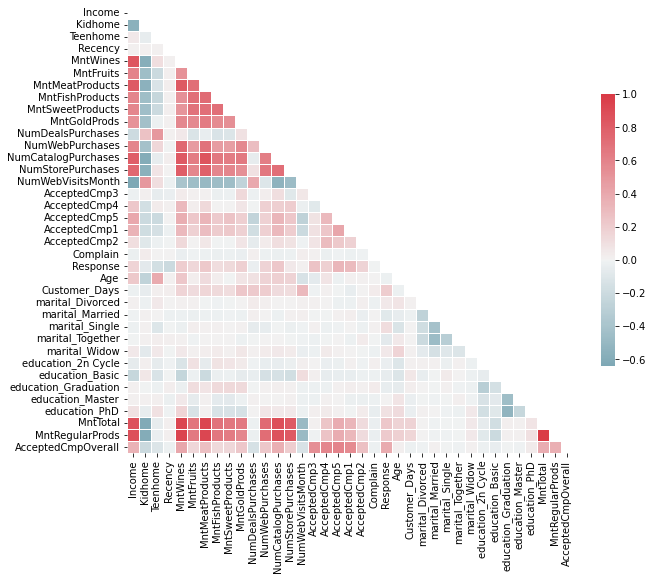

In [34]:
# Draw the heatmap with the mask and correct aspect ratio
mask = np.triu(np.ones_like(corr, dtype=np.bool))
cmap = sns.diverging_palette(, 10, as_cmap=True)
plt.subplots(figsize=(10,10))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [42]:
pd.DataFrame(corr_unstacked[(abs(corr_unstacked)>0.8)&(abs(corr_unstacked)<1)]).sort_index().style.background_gradient(cmap='coolwarm', low=., high=-.7)

In [37]:
pd.DataFrame(corr_unstacked[corr_unstacked<-.5]).sort_index().style.background_gradient(cmap='coolwarm', low=-.6, high=.5)

## Segmentation of Customers

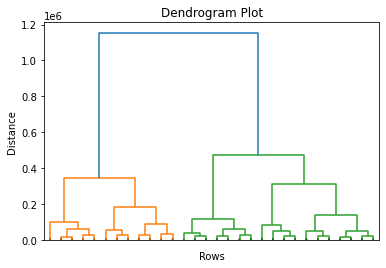

In [46]:

ifood_df_clustering = ifood_df.drop(['Z_CostContact','Z_Revenue','Response'], axis=1)

input_matrix = linkage(ifood_df_clustering, 'ward')

plt.title('Dendrogram Plot')
plt.xlabel('Rows')
plt.ylabel('Distance')

dendrogram(
    input_matrix,
    truncate_mode='lastp',show_leaf_counts=False,
    leaf_rotation=90., leaf_font_size=12., show_contracted=True,)

plt.show()

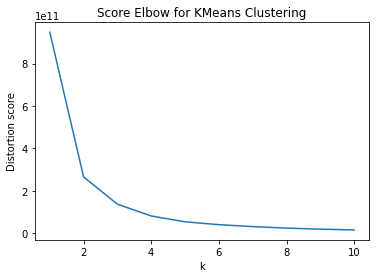

In [47]:
km_eval = []

for i in range(1,11):
    kmeans_model=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans_model.fit(ifood_df_clustering)
    km_eval.append(kmeans_model.inertia_)

# Plot Kmeans for k from 1 to 10 criterion
plt.plot(range(1,11), km_eval)
plt.title('Score Elbow for KMeans Clustering')
plt.xlabel('k')
plt.ylabel('Distortion score')
plt.show()

## Fitting kmeans to the dataset with k=3

In [48]:
## fit and predict clusters
kmeans_model = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
ifood_df_clustering['cluster'] = kmeans_model.fit_predict(ifood_df_clustering)

In [49]:
ifood_df_clustering.cluster.value_counts()

2    761
0    730
1    714
Name: cluster, dtype: int64

In [50]:
ifood_df_clustering.head()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,marital_Widow,education_2n Cycle,education_Basic,education_Graduation,education_Master,education_PhD,MntTotal,MntRegularProds,AcceptedCmpOverall,cluster
0,58138.0,0,0,58,635,88,546,172,88,88,...,0,0,0,1,0,0,1529,1441,0,2
1,46344.0,1,1,38,11,1,6,2,1,6,...,0,0,0,1,0,0,21,15,0,2
2,71613.0,0,0,26,426,49,127,111,21,42,...,0,0,0,1,0,0,734,692,0,1
3,26646.0,1,0,26,11,4,20,10,3,5,...,0,0,0,1,0,0,48,43,0,0
4,58293.0,1,0,94,173,43,118,46,27,15,...,0,0,0,0,0,1,407,392,0,2


C:\Users\punee\AppData\Local\Temp\ipykernel_30616\214466693.py:3: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  ifood_df_clustering.boxplot(column=['Income', 'Age', 'Recency', 'MntWines',


array([<AxesSubplot:title={'center':'Income'}, xlabel='cluster'>,
       <AxesSubplot:title={'center':'Age'}, xlabel='cluster'>,
       <AxesSubplot:title={'center':'Recency'}, xlabel='cluster'>,
       <AxesSubplot:title={'center':'MntWines'}, xlabel='cluster'>,
       <AxesSubplot:title={'center':'MntFruits'}, xlabel='cluster'>,
       <AxesSubplot:title={'center':'MntMeatProducts'}, xlabel='cluster'>,
       <AxesSubplot:title={'center':'MntFishProducts'}, xlabel='cluster'>,
       <AxesSubplot:title={'center':'MntSweetProducts'}, xlabel='cluster'>,
       <AxesSubplot:title={'center':'MntRegularProds'}, xlabel='cluster'>,
       <AxesSubplot:title={'center':'MntGoldProds'}, xlabel='cluster'>,
       <AxesSubplot:title={'center':'NumDealsPurchases'}, xlabel='cluster'>,
       <AxesSubplot:title={'center':'NumWebPurchases'}, xlabel='cluster'>,
       <AxesSubplot:title={'center':'NumCatalogPurchases'}, xlabel='cluster'>,
       <AxesSubplot:title={'center':'NumStorePurchases'}, xlabe

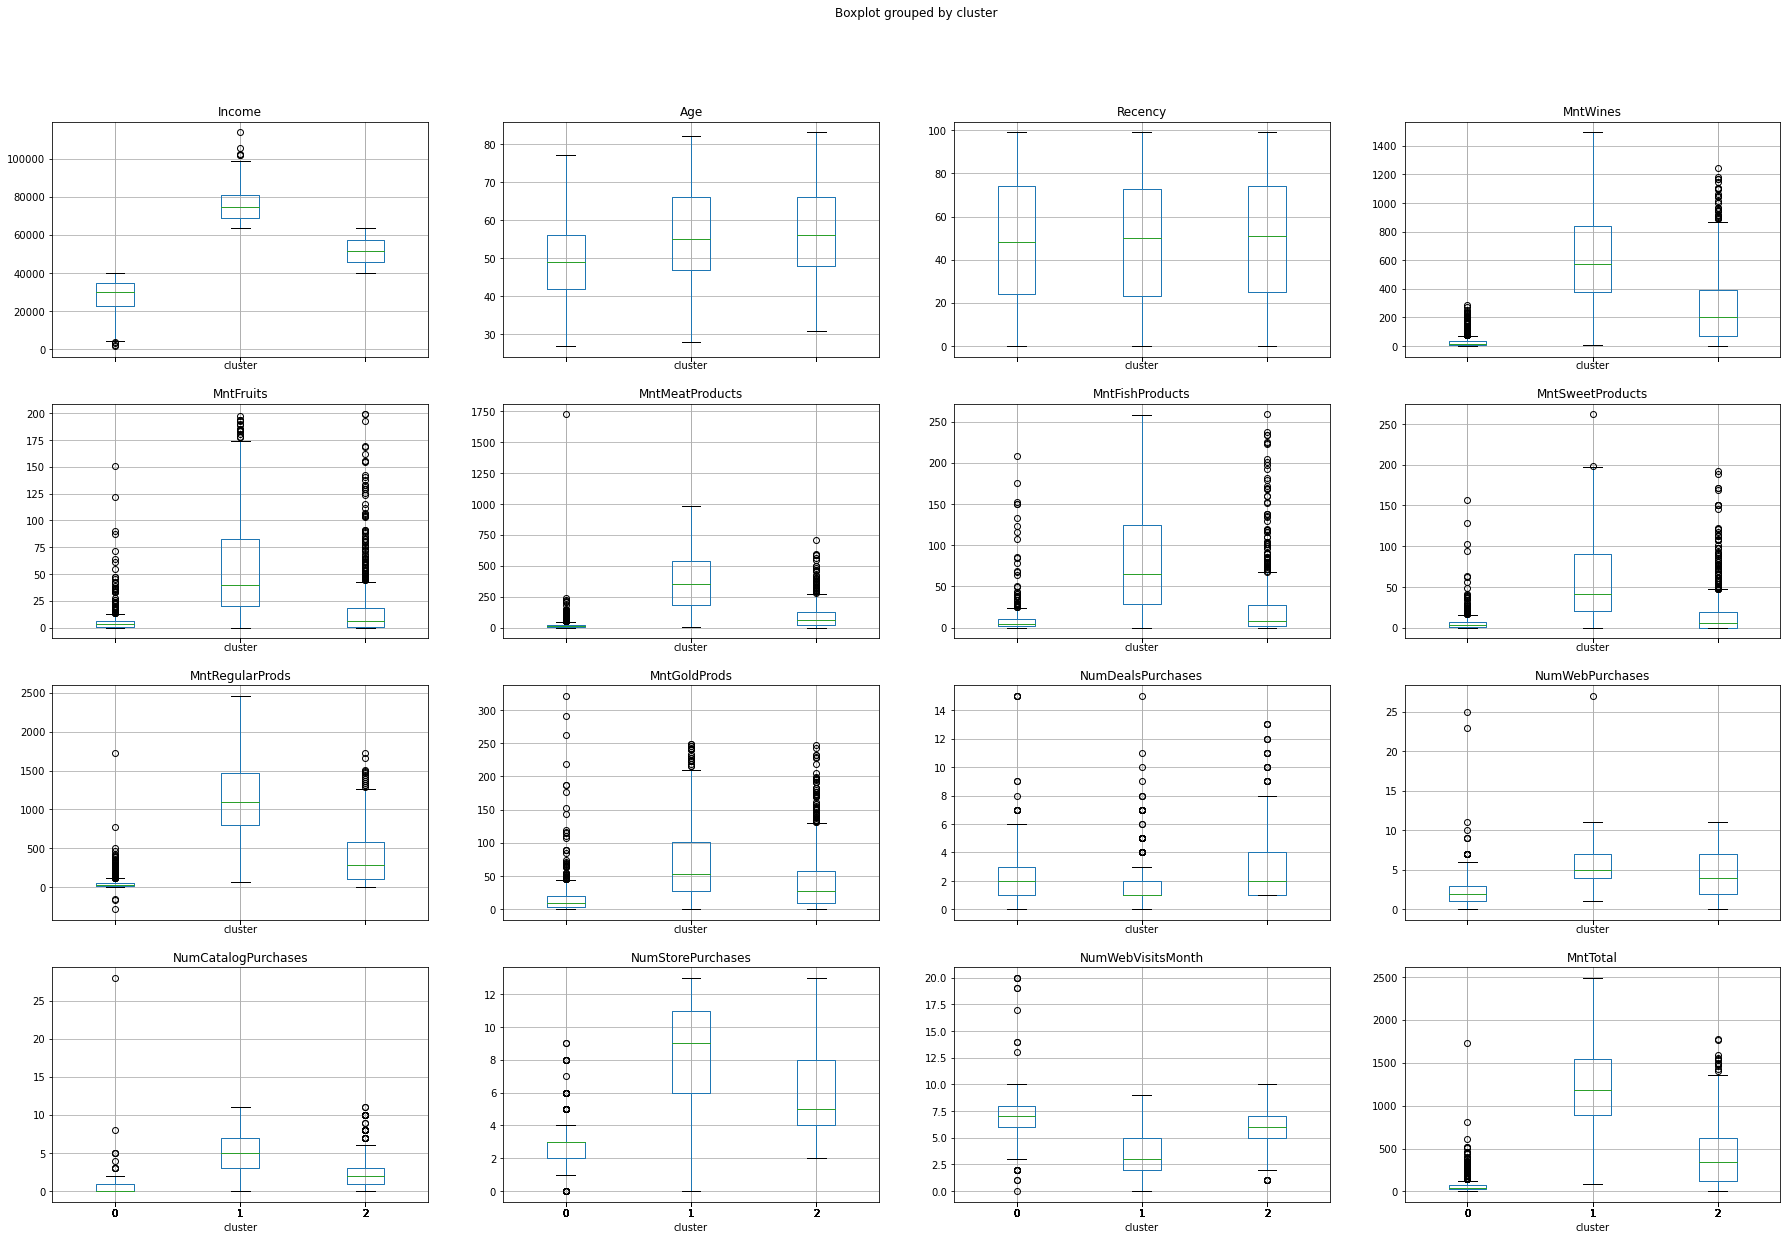

In [53]:
fig, axes = plt.subplots(4,4, sharex= True, sharey= False, figsize=(30,20))

ifood_df_clustering.boxplot(column=['Income', 'Age', 'Recency', 'MntWines',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntRegularProds','MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'MntTotal'
       ], ax = axes, by='cluster')


<AxesSubplot:xlabel='cluster', ylabel='count'>

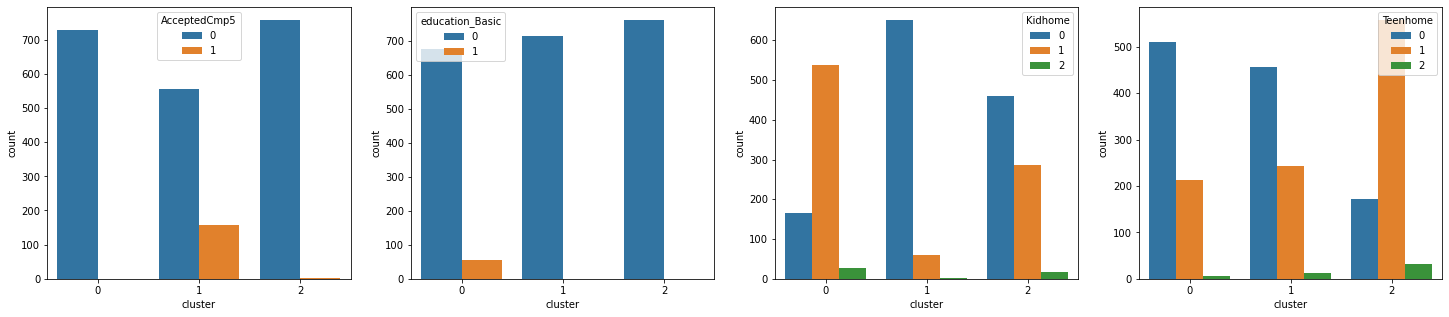

In [54]:
fig, ax = plt.subplots(1,4, figsize=(25,5))

sns.countplot(x="cluster", hue="AcceptedCmp5", data=ifood_df_clustering, ax=ax[0])
sns.countplot(x="cluster", hue="education_Basic", data=ifood_df_clustering, ax=ax[1])
sns.countplot(x="cluster", hue="Kidhome", data=ifood_df_clustering, ax=ax[2])
sns.countplot(x="cluster", hue="Teenhome", data=ifood_df_clustering, ax=ax[3])

In [56]:
ifood_df_clustering.to_csv("ifood.csv")

### Correlation Findings

1. **Income and Spending Patterns:**
   - Income serves as a proxy for various other features within the dataset. It exhibits a positive correlation with the total amount spent and is notably influenced by expenditures on meat and wine.
   - Conversely, income shows a negative correlation with the number of children at home and the frequency of website visits.

2. **Wine Spending Patterns:**
   - Expenditure on wine not only correlates positively with high income but is also linked to spending on meat. Additionally, it can be observed whether wine is purchased from catalogs or physical stores.

3. **Family Size Impact:**
   - The number of children in a household exhibits a negative correlation with income, total spending, and consequently, wine expenditures. 

4. **Income and Campaign Acceptance:**
   - Higher income levels are positively associated with a higher likelihood of accepting marketing campaigns.

These correlation findings shed light on the intricate relationships between income, spending habits, family size, and campaign acceptance within the dataset.